In [300]:
import sys
import pandas as pd 
import tensorflow as tf 
# featuretools for automated feature engineering
import featuretools as ft
import featuretools.variable_types as vtypes

from pickle import dump
from pickle import load
import numpy as np 
from sklearn import metrics
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance 

train_date = '2020-11-30'
final_date = '2021-02-10'
intfinal_date = 20210131

df_Parts_org = pd.read_csv('./data/Parts_EQP_OutPut_ByMonth_NEW.csv', encoding = 'big5')
df_Tool_org = pd.read_csv('./data/ScmTrainingData_Monthly20210331.csv', encoding = 'big5')
 
df_Tool = df_Tool_org.copy(deep=False)
df_Parts = df_Parts_org.copy(deep=False)

# df_Tool['dtSTOCK_EVENT_TIME'] = df_Tool['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d'))
# df_Parts['dtSTOCK_EVENT_TIME'] = df_Parts['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))


KeyError: 'MFG_MONTH'

In [301]:

df_Tool.head()


,MFG_MONTH,TOOL_ID,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,EQP_AVAIL_RATE,...,C_TC,ENG_LOT_RATE,HOT_LOT_RATE,BACKUP_BY_RATE,BACKUP_FOR_RATE,RWORK_LOT_RATE,QUE_LOT_RATE,SAMPLING_RATE,NUM_RECIPE,CHANGE_RECIPE
0,202001,ECT11,2.0,0.980330,0.000000,23.532338,0.000000,0.610835,0.000000,1.017413,...,0.473505,0.038901,0.029598,0,0.0,0.002537,0.971247,0,23,0.781095
1,202001,ECT12,2.0,0.955082,0.018692,23.879781,0.010288,0.773233,0.148510,2.807054,...,0.469116,0.000458,0.045995,0,0.0,0.000000,0.866590,0,16,0.874317
2,202001,ECT13,2.0,0.942105,0.020632,23.391304,0.010748,0.967372,0.184524,1.411594,...,0.584142,0.009294,0.020446,0,0.0,0.005163,0.792028,0,33,0.739130
3,202001,ECT14,2.0,0.895276,0.039846,23.898230,0.010602,0.744382,0.197580,0.938053,...,0.454077,0.000000,0.000000,0,0.0,0.015923,0.819478,0,19,0.884956
4,202001,ECT15,2.0,0.974782,0.034848,23.993939,0.010903,0.762152,0.167263,2.588679,...,0.532533,0.036878,0.078050,0,0.0,0.002778,0.954281,0,20,0.866667


In [302]:
df_Parts.head()

,PART_NO,EQP_NO,STOCK_EVENT_TIME,QTY,PM,TS
0,85-ECT0010,ECT11,2015-10-31,3.0,2.0,1.0
1,85-ECT0010,ECT11,2015-11-30,4.0,3.0,1.0
2,85-ECT0010,ECT11,2015-12-31,4.0,4.0,0.0
3,85-ECT0010,ECT11,2016-01-31,4.0,4.0,0.0
4,85-ECT0010,ECT11,2016-02-29,3.0,3.0,0.0


In [303]:
df_Parts.head()
# df_Parts['dtSTOCK_EVENT_TIME'] = df_Parts['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))
df_Parts['MFG_MONTH'] = df_Parts['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M')).dt.strftime('%Y%m')
# df_Parts.groupby(['PART_NO', 'EQP_NO'])["col3", "col4"].apply(lambda x : x.astype(int).sum())
df_Parts = df_Parts.drop(['STOCK_EVENT_TIME'], axis=1)

In [304]:
df_Tool['TRkey'] = df_Tool['MFG_MONTH'].astype('str') +'_' +df_Tool['TOOL_ID']  
df_Parts['PRkey'] = df_Parts['MFG_MONTH'].astype('str') +'_' +df_Parts['EQP_NO']  

In [305]:
# df_Parts.PUT_ON_STATUS.unique()
# df_Parts['dtSTOCK_EVENT_TIME'].dt.strftime('%Y%m%d')

# REPLACE_STATUS_values ={'廠內清洗': 0,'待報廢': 1,'備品':2,'廠外清洗':3}
# df_Parts.REPLACE_STATUS = df_Parts.REPLACE_STATUS.map(REPLACE_STATUS_values)

# PUT_ON_STATUS_values ={'clean': 0,'新品': 1,'備品':2}
# df_Parts.PUT_ON_STATUS = df_Parts.PUT_ON_STATUS.map(PUT_ON_STATUS_values)


In [306]:
df_Parts = df_Parts[ df_Parts['MFG_MONTH'].astype(int) >= df_Tool['MFG_MONTH'].min().astype(int) ]
df_Parts = df_Parts[ df_Parts['MFG_MONTH'].astype(int) <= df_Tool['MFG_MONTH'].max().astype(int) ]

In [307]:
df_Parts

,PART_NO,EQP_NO,QTY,PM,TS,MFG_MONTH,PRkey
51,85-ECT0010,ECT11,5.0,5.0,0.0,202001,202001_ECT11
52,85-ECT0010,ECT11,4.0,4.0,0.0,202002,202002_ECT11
53,85-ECT0010,ECT11,3.0,3.0,0.0,202003,202003_ECT11
54,85-ECT0010,ECT11,3.0,3.0,0.0,202004,202004_ECT11
55,85-ECT0010,ECT11,3.0,3.0,0.0,202005,202005_ECT11
...,...,...,...,...,...,...,...
2554,85-ECT0010,EUT61,6.0,6.0,0.0,202010,202010_EUT61
2555,85-ECT0010,EUT61,7.0,7.0,0.0,202011,202011_EUT61
2556,85-ECT0010,EUT61,6.0,6.0,0.0,202012,202012_EUT61
2557,85-ECT0010,EUT61,7.0,7.0,0.0,202101,202101_EUT61


In [308]:
 
es = ft.EntitySet(id = 'PART')
#Entityset 把多個實體Entity進行合併
# Product
es = es.entity_from_dataframe(entity_id = 'Tool',
             dataframe = df_Tool,  
            #  variable_types={'MFG_DATE': ft.variable_types.Categorical},
            # make_index = False, 
            # index="ID",
            # index = 'PRkey',
            index ='TRkey',
            # time_index = 'dtSTOCK_EVENT_TIME',
            # variable_types={'MFG_DATE':vtypes.Categorical},

             )
# Tool
es = es.entity_from_dataframe(entity_id = 'Parts',
             dataframe = df_Parts,  
            #  variable_types={'MFG_DATE': ft.variable_types.Categorical},
            make_index = True, 
            index="ID",
            # index = 'PRkey', 
            # time_index = 'dtSTOCK_EVENT_TIME',
           
            )   



In [309]:
print(es["Parts"].variables)
print(es["Tool"].variables)

[<Variable: ID (dtype = index)>, <Variable: PART_NO (dtype = categorical)>, <Variable: EQP_NO (dtype = categorical)>, <Variable: QTY (dtype = numeric)>, <Variable: PM (dtype = numeric)>, <Variable: TS (dtype = numeric)>, <Variable: MFG_MONTH (dtype = categorical)>, <Variable: PRkey (dtype = categorical)>]
[<Variable: TRkey (dtype = index)>, <Variable: MFG_MONTH (dtype = numeric)>, <Variable: TOOL_ID (dtype = categorical)>, <Variable: M_NUM (dtype = numeric)>, <Variable: UP_TIME (dtype = numeric)>, <Variable: C_UP_TIME (dtype = numeric)>, <Variable: LOT_SIZE (dtype = numeric)>, <Variable: C_LOT_SIZE (dtype = numeric)>, <Variable: EQP_UTIL (dtype = numeric)>, <Variable: C_EQP_UTIL (dtype = numeric)>, <Variable: EQP_AVAIL_RATE (dtype = numeric)>, <Variable: TC (dtype = numeric)>, <Variable: PROCESS_TIME (dtype = numeric)>, <Variable: PROCESS_JOBTIME (dtype = numeric)>, <Variable: INLINE_CT_LOT (dtype = numeric)>, <Variable: INLINE_CT_WAFER (dtype = numeric)>, <Variable: MOVE_QTY (dtype = 

In [310]:
# %%
r= ft.Relationship(es['Tool']['TRkey'],es['Parts']['PRkey'])
es = es.add_relationship(r)


In [311]:
# es['Product']['PROD_ID'].interesting_values = df_Product['PROD_ID'].unique()# ['Approved', 'Refused', 'Canceled'] 
# df_Product['PROD_ID'].unique()
PartsTool_matrix,PartsTool_names= ft.dfs( entityset = es,
                agg_primitives=['std','trend'], #'count',
                trans_primitives=["percentile"], #weekday","is_weekend", "percentile"
                # where_primitives = ['cum_count'], 
                #where_primitives = ['mean', 'mode'], 

                # groupby_trans_primitives=['cum_count'], #累積總計、累積總數
                primitive_options={
                    # 'percentile': {
                    #         'include_variables':
                    #             {'Product': ['ProdWIP','ProdHoldWIP']},
                    #         # 'ignore_variables':
                    #         #     {'Porduct': ['MOVE_P']}    
                                
                    #   },
                        # 'cum_count': {
                        #         'include_variables':
                        #             {'WIP': ['WIP_QTY']},
                        #         'ignore_variables':
                        #             {'WIP': ['IS_MAIN_ROUTE']}    
                                    
                        #             },
                        # 'is_weekend': {
                        #         'ignore_variables':
                        #                 {'WIP': ['ACTUAL_WP_OUT']}}
                },

                target_entity='Parts')
# ProductTool_matrix['Machine.COUNT(Product)']         
list(PartsTool_matrix.columns)       


C:\ProgramData\Anaconda3\envs\PY379\lib\site-packages\featuretools\synthesis\dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['trend']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


['PART_NO',
 'EQP_NO',
 'QTY',
 'PM',
 'TS',
 'MFG_MONTH',
 'PRkey',
 'PERCENTILE(PM)',
 'PERCENTILE(QTY)',
 'PERCENTILE(TS)',
 'Tool.MFG_MONTH',
 'Tool.TOOL_ID',
 'Tool.M_NUM',
 'Tool.UP_TIME',
 'Tool.C_UP_TIME',
 'Tool.LOT_SIZE',
 'Tool.C_LOT_SIZE',
 'Tool.EQP_UTIL',
 'Tool.C_EQP_UTIL',
 'Tool.EQP_AVAIL_RATE',
 'Tool.TC',
 'Tool.PROCESS_TIME',
 'Tool.PROCESS_JOBTIME',
 'Tool.INLINE_CT_LOT',
 'Tool.INLINE_CT_WAFER',
 'Tool.MOVE_QTY',
 'Tool.C_TC',
 'Tool.ENG_LOT_RATE',
 'Tool.HOT_LOT_RATE',
 'Tool.BACKUP_BY_RATE',
 'Tool.BACKUP_FOR_RATE',
 'Tool.RWORK_LOT_RATE',
 'Tool.QUE_LOT_RATE',
 'Tool.SAMPLING_RATE',
 'Tool.NUM_RECIPE',
 'Tool.CHANGE_RECIPE',
 'Tool.STD(Parts.PM)',
 'Tool.STD(Parts.QTY)',
 'Tool.STD(Parts.TS)',
 'Tool.PERCENTILE(BACKUP_BY_RATE)',
 'Tool.PERCENTILE(BACKUP_FOR_RATE)',
 'Tool.PERCENTILE(CHANGE_RECIPE)',
 'Tool.PERCENTILE(C_EQP_UTIL)',
 'Tool.PERCENTILE(C_LOT_SIZE)',
 'Tool.PERCENTILE(C_TC)',
 'Tool.PERCENTILE(C_UP_TIME)',
 'Tool.PERCENTILE(ENG_LOT_RATE)',
 'Tool.PE

In [312]:
# https://docs.featuretools.com/en/stable/api_reference.html#aggregation-primitives
# ft.primitives.list_primitives()
# ProductTool_matrix[['Machine.MFG_DATE']]['Machine.MFG_DATE'].max()
#select features that have at least 2 unique values and that are not all null
#(feature_matrix, features=None):
from featuretools.selection import remove_low_information_features  ## 移除较小信息的特征

#Removes columns from a feature matrix that have higher than a set threshold of null values.
#(feature_matrix, features=None, pct_null_threshold=0.95):
from featuretools.selection import remove_highly_null_features

#Removes columns in feature matrix where all the values are the same.
#(feature_matrix, features=None, count_nan_as_value=False):
from featuretools.selection import remove_single_value_features

#Removes columns in feature matrix that are highly correlated with another column.
#(feature_matrix, features=None, pct_corr_threshold=0.95,features_to_check=None, features_to_keep=None):
from featuretools.selection import remove_highly_correlated_features 
feature_matrix = PartsTool_matrix.copy(deep=True)
features_list = PartsTool_names
features1= PartsTool_matrix.copy(deep=True)
feature_names1 = PartsTool_names

# print('features',PartsTool_matrix.shape)
# features1, feature_names1 = remove_low_information_features(feature_matrix, features_list)
# print('被刪除的欄位 remove_low_information_features',feature_matrix.shape)
# print('Removed %d features from training features' % (feature_matrix.shape[1] - features1.shape[1])) 
# print(set(feature_matrix) - set(features1))

# features1, feature_names1 = remove_highly_null_features(features1, feature_names1,0.95)
# print('被刪除的欄位 remove_highly_null_features',features1.shape)
# print('Removed %d features from training features' % (feature_matrix.shape[1] - features1.shape[1])) 
# print(set(feature_matrix) - set(features1))

# features1, feature_names1 = remove_single_value_features(features1, feature_names1)
# print('被刪除的欄位 remove_single_value_features',features1.shape)
# print('Removed %d features from training features' % (feature_matrix.shape[1] - features1.shape[1])) 
# print(set(feature_matrix) - set(features1))

# features1, feature_names1 = remove_highly_correlated_features(features1, feature_names1,0.95)
# print('被刪除的欄位 remove_highly_correlated_features',features1.shape)
# print('Removed %d features from training features' % (feature_matrix.shape[1] - features1.shape[1])) 
# print(set(feature_matrix) - set(features1))

#此兩個欄位 後面資料處理要用來比對資料，所以不能被刪除
features1['PART_NO']=feature_matrix['PART_NO']

print(features1.head())
print(list(features1.columns)  )

       PART_NO EQP_NO  QTY   PM   TS MFG_MONTH         PRkey  PERCENTILE(PM)  \
ID                                                                             
0   85-ECT0010  ECT11  5.0  5.0  0.0    202001  202001_ECT11        0.427700   
1   85-ECT0010  ECT11  4.0  4.0  0.0    202002  202002_ECT11        0.250000   
2   85-ECT0010  ECT11  3.0  3.0  0.0    202003  202003_ECT11        0.109756   
3   85-ECT0010  ECT11  3.0  3.0  0.0    202004  202004_ECT11        0.109756   
4   85-ECT0010  ECT11  3.0  3.0  0.0    202005  202005_ECT11        0.109756   

    PERCENTILE(QTY)  PERCENTILE(TS)  ...  Tool.PERCENTILE(MOVE_QTY)  \
ID                                   ...                              
0          0.426829             0.5  ...                   0.071429   
1          0.250000             0.5  ...                   0.602787   
2          0.109756             0.5  ...                   0.738676   
3          0.109756             0.5  ...                   0.719512   
4          0.

In [313]:
features1.to_csv('features1.csv')

In [314]:
list(features1.columns)   

['PART_NO',
 'EQP_NO',
 'QTY',
 'PM',
 'TS',
 'MFG_MONTH',
 'PRkey',
 'PERCENTILE(PM)',
 'PERCENTILE(QTY)',
 'PERCENTILE(TS)',
 'Tool.MFG_MONTH',
 'Tool.TOOL_ID',
 'Tool.M_NUM',
 'Tool.UP_TIME',
 'Tool.C_UP_TIME',
 'Tool.LOT_SIZE',
 'Tool.C_LOT_SIZE',
 'Tool.EQP_UTIL',
 'Tool.C_EQP_UTIL',
 'Tool.EQP_AVAIL_RATE',
 'Tool.TC',
 'Tool.PROCESS_TIME',
 'Tool.PROCESS_JOBTIME',
 'Tool.INLINE_CT_LOT',
 'Tool.INLINE_CT_WAFER',
 'Tool.MOVE_QTY',
 'Tool.C_TC',
 'Tool.ENG_LOT_RATE',
 'Tool.HOT_LOT_RATE',
 'Tool.BACKUP_BY_RATE',
 'Tool.BACKUP_FOR_RATE',
 'Tool.RWORK_LOT_RATE',
 'Tool.QUE_LOT_RATE',
 'Tool.SAMPLING_RATE',
 'Tool.NUM_RECIPE',
 'Tool.CHANGE_RECIPE',
 'Tool.STD(Parts.PM)',
 'Tool.STD(Parts.QTY)',
 'Tool.STD(Parts.TS)',
 'Tool.PERCENTILE(BACKUP_BY_RATE)',
 'Tool.PERCENTILE(BACKUP_FOR_RATE)',
 'Tool.PERCENTILE(CHANGE_RECIPE)',
 'Tool.PERCENTILE(C_EQP_UTIL)',
 'Tool.PERCENTILE(C_LOT_SIZE)',
 'Tool.PERCENTILE(C_TC)',
 'Tool.PERCENTILE(C_UP_TIME)',
 'Tool.PERCENTILE(ENG_LOT_RATE)',
 'Tool.PE

In [315]:

# 避免資料在處理過程中，把預測的相關資料也放進去 訓練集 :在此統一排除
# list(features1.columns)    
# print(len(features1.filter(regex='(Product.MOVE_P)+',axis=1).columns))
# if (len(features1.filter(regex='(Product.MOVE_P)+',axis=1).columns)) >0:
#     features1.drop(ProductTool_matrix.filter(regex='(Product.MOVE_P)+',axis=1).columns, axis=1,inplace = True) 

# print(len(features1.filter(regex='(Product.ProdMove)+',axis=1).columns))    
# if (len(features1.filter(regex='(Product.ProdMove)+',axis=1).columns)) >0:
#     features1.drop(ProductTool_matrix.filter(regex='(Product.ProdMove)+',axis=1).columns, axis=1,inplace = True) 

# ============================================
# ProductTool_matrix.drop(ProductTool_matrix.filter(regex='(Product.ProdMove)+',axis=1).columns, axis=1,inplace = True).columns
# pattern = '*(Product.MOVE_P)'
# matching = list(ProductTool_matrix.columns).filter(l, pattern)
# print(matching)

In [316]:
# df = df[df.columns.intersection(myFeatures)]
drop_cols=['PRkey','MFG_MONTH','PERCENTILE(PM)','PERCENTILE(TS)','PERCENTILE(QTY)', 'PERCENTILE(TS)','PM','TS','Tool.MFG_MONTH', 'Tool.TOOL_ID']
df.columns.intersection(drop_cols)

Index(['PM', 'TS', 'MFG_MONTH', 'PRkey', 'PERCENTILE(PM)', 'PERCENTILE(QTY)',
       'PERCENTILE(TS)', 'Tool.MFG_MONTH', 'Tool.TOOL_ID'],
      dtype='object')

In [317]:
# # 資料清洗
# target_cols=['MOVE_P']
# cat_cols = ['PROD_ID','TOOLG_ID']
# drop_cols=['PPkey']
# aa = [e for e in df_test.columns.to_list() if e not in cat_cols+target_cols+drop_cols]
# # .remove(target_cols)
# # list(df_test).remove(cat_cols)
 

def preHandleDat(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

 
    #=================
    #刪除不必要的欄位
    #=================
    # drop_cols=['MFG_DATE','PPkey','PRkey','TRkey','dtMFG_DATE','dtMFG_DATE']
    drop_cols=['PRkey','MFG_MONTH','PERCENTILE(PM)','PERCENTILE(TS)','PERCENTILE(QTY)', 'PERCENTILE(TS)','PM','TS','Tool.MFG_MONTH', 'Tool.TOOL_ID']
    drop_cols=df.columns.intersection(drop_cols)
    df = df.drop(drop_cols, axis=1)
    # if(len(drop_cols)>0):
    #     df = df.drop(drop_cols, axis=1)
     
    
    target_cols=['QTY']
    cat_cols = ['PART_NO','EQP_NO']
    num_cols =[e for e in df.columns.to_list() if e not in cat_cols+target_cols]

    df =  df.dropna(subset=target_cols,thresh=1)
    # print(df)   
    
    #========================
    # 缺漏值填空
    #========================
    #df_train['PROCESS_TIME'] = df_train['PROCESS_TIME'].replace(to_replace=0, method='ffill')
    df = df.fillna(df.median())
    #df = df.fillna(method='bfill') #往後
    #df = df.fillna(method='ffill') #往前
    # df = df.fillna(df.mean())  #用平均值取代 nan   
     
    #df['ColA'].fillna(value=0, inplace=True) #用 0 取代 nan
    #df['ColA'].fillna(value=df.groupby('ColB')['ColA'].transform('mean'), inplace=True) #利用 groupby()同一group 的平均值
    df = df.fillna(value=0)
    #==================================================
    #1.特徵縮放
    #==================================================

    df_train_scal = df.copy(deep=False)
    global df_cols
    df_cols = df_train_scal.columns
    
    if isTrain:
        
        
        #rescaling 特徵縮放 StandardScaler-------------------------------------
        # scaler = StandardScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])
    
        #rescaling 特徵縮放 MinMaxScaler-------------------------------------
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
        df_train_scal[num_cols]= scaler.transform(df_train_scal[num_cols])

        #rescaling 特徵縮放 RobustScaler-------------------------------------
        # scaler = RobustScaler()
        # scaler.fit(df_train[num_cols])
        # df_train_scal[num_cols] = scaler.transform(df_train_scal[num_cols])
        
        dump(scaler, open('scaler.pkl', 'wb'))
        # # save the scaler
        # dump(scaler, open('scaler.pkl', 'wb'))
    else:
        # load the scaler
        scaler = load(open('scaler.pkl', 'rb'))
        df_train_scal[num_cols] = scaler.transform(df[num_cols])
     #==================================================
    #2.one hot encoder
    #==================================================
    # target_cols=['MOVE_QTY']
 
    global df2_train_eh_before
    df_train_eh =pd.get_dummies(df_train_scal.drop(target_cols, axis=1),columns=cat_cols)
    # save the scaler


    if isTrain:
        df2_train_eh_before = df_train_eh.copy(deep=False)
    else:
        df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)

    df_train_scal.to_csv('./df_train_scal.csv')
           
    X_dropped = np.asarray(df_train_eh)
    Y_dropped = np.asarray(df[target_cols]) 
    # print(df_train_eh)
    return X_dropped,Y_dropped



In [318]:
# preHandleDat(feature_matrix,True)
def iqrfilter(df, colname, bounds = [.25, .75]):
    s = df[colname]
    Q1 = df[colname].quantile(bounds[0])
    Q3 = df[colname].quantile(bounds[1])
    IQR = Q3 - Q1
    # print(IQR,Q1,Q3,Q1 - 1.5*IQR,Q3+ 1.5 * IQR)
    if bounds[0]==0:
        return df[~s.clip(*[Q1,Q3+ 1.5 * IQR]).isin([Q1,Q3+ 1.5 * IQR])]
    else:
        return df[~s.clip(*[Q1 - 1.5*IQR,Q3+ 1.5 * IQR]).isin([Q1 - 1.5*IQR,Q3+ 1.5 * IQR])]

def trainLR(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.01,random_state=123)
    
    model = LinearRegression(fit_intercept=False, normalize=False, copy_X=False) #fit_intercept=False
   
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    #print(y_predict)
    print("r2:", model.score(X_test, y_test))# 拟合优度R2的输出方法
    print("MAE:", metrics.mean_absolute_error(y_test, y_predict))# 用Scikit_learn计算MAE
    print("MSE:", metrics.mean_squared_error(y_test, y_predict)) # 用Scikit_learn计算MSE
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))# 用Scikit_learn计算RMSE
    print("intercept_ :",model.intercept_)
    # print("coef_", model.coef_)
    joblib.dump(model, 'LR_model')
    # print(1- abs((def_result['predict'] - def_result['TRCT'])/def_result['TRCT'] ))#計算準確率分數)

    # print((y_predict-y_test)/y_test)
    # reg = LinearRegression().fit(X, y)
 
    # line_poly = poly.transform(line)
    # plt.plot(line, reg.predict(line), label='linear regression')
    # plt.plot(X[:, 0], y, 'o', c='k')
    # plt.ylabel("Regression output")
    # plt.xlabel("Input feature")
    # plt.legend(loc="best")
 

    return y_predict


# %%
def testLR(df):
    from sklearn.linear_model import LinearRegression
    
    X_test,y_test = preHandleDat(df,False)
 
    loaded_model = joblib.load('LR_model')
    y_predict = loaded_model.predict(X_test)
    df_result=df.copy(deep=True)
    df_result['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    print('acc:',accsum(df_result))

    t = np.arange(len(X_test))# 创建t变量
    drawModelResult('LR','',t,y_test, y_predict,'./Result/LR.png')

    return df_result


# %%
def trainXG(df):
    import xgboost as xgb
    
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=587)
    cv_params = {'n_estimators': [300,400,500,600],'max_depth':[7,11,13,15,17],'min_child_weight':[1,3,5,7,9]}
    other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
    model = xgb.XGBRegressor(**other_params)
    bst_model=model
    # optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)

    # optimized_GBM.fit(X_train, y_train) 

    # test_score = optimized_GBM.score(X_test,y_test)

    # print('test 得分:{0}'.format(test_score))
    # # evalute_result = optimized_GBM.grid_scores_
    # # print('每輪迭代執行結果:{0}'.format(evalute_result))
    
    # print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
    # print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    # print('cv_results_',optimized_GBM.cv_results_)

    # bst_model = optimized_GBM.estimator
    # print(bst_model)

    
    bst_model.fit(X_train, y_train)
    # plot_importance(bst_model)#,max_num_features=10)
    # plt.show()

    joblib.dump(bst_model, 'XG_model')


# %%
def testXG(df):
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    df_result=df.copy(deep=True)
    loaded_model = joblib.load('XG_model')
    y_predict = loaded_model.predict(X_test)
    df_result['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("r2:", loaded_model.score(X_test, y_test))
    print('acc:',accsum(df_result))
    
 
    t = np.arange(len(X_test))# 创建t变量
    drawModelResult('LR','',t,y_test, y_predict,'./Result/XGtest.png')
    
    return df_result


# %%
def trainNN(df):
    import tensorflow as tf
    save_model_tool = './NN/training_model2.h5'
    # save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)
    df_result = df.copy(deep=False)
    X_dropped, Y_dropped = preHandleDat(df_result,True)
    # tuneNN(X_dropped,Y_dropped)
    
    # 拆分train validation set NN fit 可以自己拆
    # X_train, X_test,y_train,y_test = train_test_split(X_dropped,Y_dropped,test_size =0.1,random_state=587)
    
    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)

        
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        # tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),

        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform',activation='relu')
        

        ])
    #model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

        #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
        #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
        
        # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
        # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
        # 
    #--------------------------
    #[Keras 損失函數(loss)]
        #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
        #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
        #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
        #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    #========================================================================
    # SGD
    sgd = tf.keras.optimizers.SGD(lr=0.20, momentum=0.0, decay=0.0, nesterov=False)
    # 随机梯度下降优化器。
    # 包含扩展功能的支持： - 动量（momentum）优化, - 学习率衰减（每次参数更新后） - Nestrov 动量 (NAG) 优化
    # 参数
    # lr: float >= 0. 学习率。
    # momentum: float >= 0. 参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
    # decay: float >= 0. 每次参数更新后学习率衰减值。
    # nesterov: boolean. 是否使用 Nesterov 动量。
    #========================================================================
    # compile 編譯模型
    # model.compile(loss='mean_squared_error', optimizer='adam'
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 」‘「＝、
    
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=0.01,decay=1e-6, momentum=0.9, nesterov=True)
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 
    # model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])
    
    # model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])   
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01) #, optimizer=tf.keras.optimizers.SGD(lr=0.2)
                        , metrics = [ 'mae', 'mape'])   
    
    #model = tuningNN(model,X_dropped,Y_dropped)                                            
    #======================================================================================

    #3.訓練 fit：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.10, epochs=75, batch_size=50, verbose=0) #,shuffle=True validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model_tool)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    # scores = model.evaluate(X_dropped, Y_dropped) 
    
    # print("Finished training the model",scores)
    print(train_history.history.keys())
    #dict_keys(['loss', 'accuracy', 'mse', 'mae', 'mape', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape'])
    
    # 當RMSE收斂至接近0.02，且MAPE接近10%，即完成模型之訓練
    figure, axis_1 = plt.subplots()
    # plt.title(df['TOOLG_ID'].iloc[0]) # title
    plt.title('NN') # title
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")

    loss = axis_1.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    # ac =axis_1.plot(train_history.history['accuracy'], label = 'accuracy' )# 準確度
    # ac =axis_1.plot(train_history.history['mse'], label = 'mse' )# 準確度
    
    
    
    # mse = axis_1.plot(train_history.history['mse'], label = 'mse' ) 
    # vallossaxis_1= axis_1.plot(train_history.history['val_loss'], label = 'val_loss' )# 準確度
    axis_2 = axis_1.twinx()
    # mse = axis_2.plot(train_history.history['mse'], label = 'mse',color='red' ) 
    mse = axis_2.plot(train_history.history['mape'], label = 'mape',color='red' ) 
    
    # mape = axis_2.plot(train_history.history['mape'], label = 'mape' )# 準確度 接近10%
        
    axis_1.legend(loc='upper left',fontsize='large')
    axis_2.legend(loc='upper right',fontsize='large')
    # plt.legend((ac, valloss, mse, mape),
    #        ('Low accuracy', 'val_loss', 'mse', 'mape'),
    #        scatterpoints=1,
    #        loc='upper right',
    #     #    ncol=3,
    #        fontsize=14)

    plt.show()

    from sklearn.metrics import mean_squared_error #均方誤差
    from sklearn.metrics import mean_absolute_error #平方絕對誤差
    from sklearn.metrics import r2_score#R square
    #呼叫
    y_predict = model.predict(X_dropped)
    #print(np.count_nonzero(~np.isnan(Y_dropped)),np.count_nonzero(~np.isnan(y_predict)))
    Y_dropped = np.nan_to_num(np.nan, copy=True)
    # Y_dropped = np.nan_to_num(np.nan, copy=True)
    
    # print("mean_squared_error",mean_squared_error(Y_dropped,y_predict))
    # print("mean_absolute_error",mean_absolute_error(Y_dropped,y_predict))
    # print("r2_score",r2_score(Y_dropped,y_predict))
    #return df_test_eh


# %%
def testNN(df):
    import tensorflow as tf
    save_model_tool = './NN/training_model2.h5'
    model = tf.keras.models.load_model(save_model_tool)
    df_result=df.copy(deep=True)
    
    X_dropped,Y_dropped = preHandleDat(df,False)
    y_predict = model.predict(X_dropped)
    df_result['predict'] = y_predict # 預測
    
    print('acc:',accsum(df_result))
    
 
    t = np.arange(len(X_dropped))# 创建t变量
    drawModelResult('LR','',t,Y_dropped, y_predict,'./Result/NNtest.png')
    

    return df_result


 


In [319]:

def drawModelResult(modelType,TOOLG_ID,x,y_actual,y_predict28 ,imagepath):

    plt.figure(figsize=(20, 5))# 圖片尺寸
        
    plt.title('TOOLG_ID:'+ TOOLG_ID+ " ("+modelType+")")
    
    plt.plot(x, y_actual, 'b', linewidth=0, marker='x', label='actual') 
    plt.plot(x, y_predict28, 'r', linewidth=1, marker='.', label='predict on 28 days')  
    # plt.plot(x, y_predict_actrual, 'k', linewidth=1, marker='.', label='predict on actual') 
    plt.legend()
    plt.savefig(imagepath)


# %%
def accsum(def_result,target_col='QTY'):
    _accsum=0
    def_result[def_result[target_col] ==0.0][target_col]  =0.0001
    def_result[def_result['predict'] <0]['predict']  =0
    for index,row in def_result.iterrows():
        if row[target_col] <0 :
            row[target_col]  =0.00001
        if row[target_col] ==0.0:
            row[target_col]  =0.00001
        # print(row['TRCT'] )
        if 1- abs((row['predict'] - row[target_col])/row[target_col] ) >0 :
            
            _accsum+=(1- abs((row['predict'] - row[target_col])/row[target_col] ))
    
    return _accsum/def_result.shape[0]

In [320]:
df

,ID,PART_NO,EQP_NO,QTY,PM,TS,MFG_MONTH,PRkey,PERCENTILE(PM),PERCENTILE(QTY),...,Tool.PERCENTILE(MOVE_QTY),Tool.PERCENTILE(M_NUM),Tool.PERCENTILE(NUM_RECIPE),Tool.PERCENTILE(PROCESS_JOBTIME),Tool.PERCENTILE(PROCESS_TIME),Tool.PERCENTILE(QUE_LOT_RATE),Tool.PERCENTILE(RWORK_LOT_RATE),Tool.PERCENTILE(SAMPLING_RATE),Tool.PERCENTILE(TC),Tool.PERCENTILE(UP_TIME)
0,0,85-ECT0010,ECT11,5.0,5.0,0.0,202001,202001_ECT11,0.427700,0.426829,...,0.071429,0.366725,0.255226,0.160279,0.139373,0.627178,0.473868,0.500871,0.186736,0.954704
1,1,85-ECT0010,ECT11,4.0,4.0,0.0,202002,202002_ECT11,0.250000,0.250000,...,0.602787,0.366725,0.510453,0.231707,0.203833,0.534843,0.491289,0.500871,0.387435,0.883275
2,2,85-ECT0010,ECT11,3.0,3.0,0.0,202003,202003_ECT11,0.109756,0.109756,...,0.738676,0.366725,0.758711,0.198606,0.191638,0.404181,0.810105,0.500871,0.340314,0.888502
3,3,85-ECT0010,ECT11,3.0,3.0,0.0,202004,202004_ECT11,0.109756,0.109756,...,0.719512,0.366725,0.697735,0.141115,0.123693,0.442509,0.513937,0.500871,0.146597,0.930314
4,4,85-ECT0010,ECT11,3.0,3.0,0.0,202005,202005_ECT11,0.109756,0.109756,...,0.506969,0.366725,0.722125,0.085366,0.081882,0.428571,0.104530,0.500871,0.090750,0.505226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,569,85-ECT0010,EUT61,6.0,6.0,0.0,202010,202010_EUT61,0.618467,0.617596,...,0.149826,0.366725,0.068815,0.827526,0.886760,0.943380,0.360627,0.500871,0.959860,0.463415
570,570,85-ECT0010,EUT61,7.0,7.0,0.0,202011,202011_EUT61,0.759582,0.759582,...,0.174216,0.366725,0.094077,0.871080,0.921603,0.834495,0.285714,0.500871,0.914485,0.139373
571,571,85-ECT0010,EUT61,6.0,6.0,0.0,202012,202012_EUT61,0.618467,0.617596,...,0.212544,0.366725,0.068815,0.858885,0.890244,0.943380,0.104530,0.500871,0.923211,0.385017
572,572,85-ECT0010,EUT61,7.0,7.0,0.0,202101,202101_EUT61,0.759582,0.759582,...,0.222997,0.366725,0.068815,0.867596,0.919861,0.943380,0.104530,0.500871,0.904014,0.235192


In [321]:

df = pd.DataFrame(features1.to_records())# <==很重要~~~~~
# df['Machine.MFG_DATE'] = df['Machine.MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 
# pd.to_datetime(final_date)
df_Parts = df_Parts[df_Parts['MFG_MONTH'].astype(int) >= df_Tool['MFG_MONTH'].min().astype(int) ]

# %%
df_train = df[ df['MFG_MONTH'].astype(int) < 202011]
df_test = df[ df['MFG_MONTH'].astype(int) ==202012]


# %%
# df_train =iqrfilter(df_train,'Machine.M_NUM',[0.25, 1]) 


# %%
# df_train.columns




In [322]:
df_train

,ID,PART_NO,EQP_NO,QTY,PM,TS,MFG_MONTH,PRkey,PERCENTILE(PM),PERCENTILE(QTY),...,Tool.PERCENTILE(MOVE_QTY),Tool.PERCENTILE(M_NUM),Tool.PERCENTILE(NUM_RECIPE),Tool.PERCENTILE(PROCESS_JOBTIME),Tool.PERCENTILE(PROCESS_TIME),Tool.PERCENTILE(QUE_LOT_RATE),Tool.PERCENTILE(RWORK_LOT_RATE),Tool.PERCENTILE(SAMPLING_RATE),Tool.PERCENTILE(TC),Tool.PERCENTILE(UP_TIME)
0,0,85-ECT0010,ECT11,5.0,5.0,0.0,202001,202001_ECT11,0.427700,0.426829,...,0.071429,0.366725,0.255226,0.160279,0.139373,0.627178,0.473868,0.500871,0.186736,0.954704
1,1,85-ECT0010,ECT11,4.0,4.0,0.0,202002,202002_ECT11,0.250000,0.250000,...,0.602787,0.366725,0.510453,0.231707,0.203833,0.534843,0.491289,0.500871,0.387435,0.883275
2,2,85-ECT0010,ECT11,3.0,3.0,0.0,202003,202003_ECT11,0.109756,0.109756,...,0.738676,0.366725,0.758711,0.198606,0.191638,0.404181,0.810105,0.500871,0.340314,0.888502
3,3,85-ECT0010,ECT11,3.0,3.0,0.0,202004,202004_ECT11,0.109756,0.109756,...,0.719512,0.366725,0.697735,0.141115,0.123693,0.442509,0.513937,0.500871,0.146597,0.930314
4,4,85-ECT0010,ECT11,3.0,3.0,0.0,202005,202005_ECT11,0.109756,0.109756,...,0.506969,0.366725,0.722125,0.085366,0.081882,0.428571,0.104530,0.500871,0.090750,0.505226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,565,85-ECT0010,EUT61,6.0,6.0,0.0,202006,202006_EUT61,0.618467,0.617596,...,0.214286,0.366725,0.172474,0.841463,0.944251,0.943380,0.104530,0.500871,0.369983,0.296167
566,566,85-ECT0010,EUT61,5.0,5.0,0.0,202007,202007_EUT61,0.427700,0.426829,...,0.118467,0.366725,0.118467,0.846690,0.904181,0.630662,0.104530,0.500871,0.602094,0.170732
567,567,85-ECT0010,EUT61,8.0,8.0,0.0,202008,202008_EUT61,0.838850,0.838850,...,0.228223,0.366725,0.068815,0.822300,0.916376,0.857143,0.247387,0.500871,0.935428,0.263066
568,568,85-ECT0010,EUT61,4.0,4.0,0.0,202009,202009_EUT61,0.250000,0.250000,...,0.167247,0.366725,0.106272,0.834495,0.902439,0.943380,0.104530,0.500871,0.933682,0.721254


-----RUN LR train------
r2: 0.9683459643198293
MAE: 0.3709743046490024
MSE: 0.22284441118840168
RMSE: 0.472063990565264
intercept_ : 0.0
-----RUN LR validation train------
r2: 0.8839046373975095
acc: 0.8640255928879613
-----RUN LR test------
r2: 0.6092209754201265
acc: 0.8154758602737637
-----RUN XG train------
-----RUN XG validation train------
r2: 0.9597380250363594
acc: 0.9538398897401639
-----RUN XG test------
r2: 0.7006414910799146
acc: 0.8042933924285502
-----RUN NN train------
dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


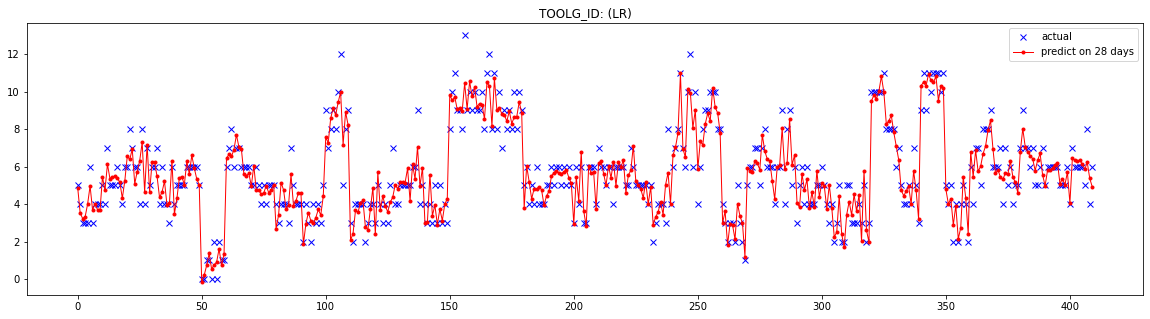

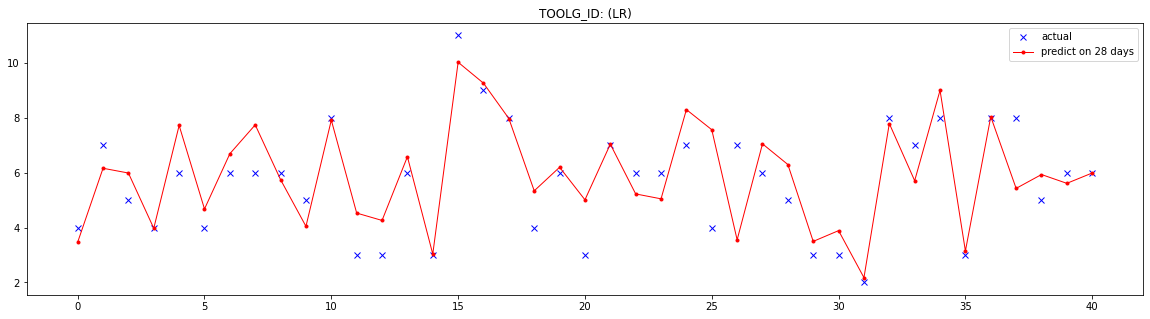

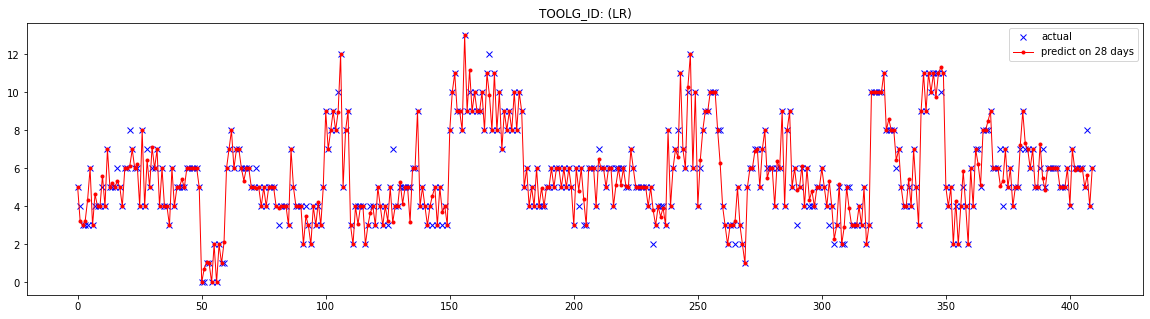

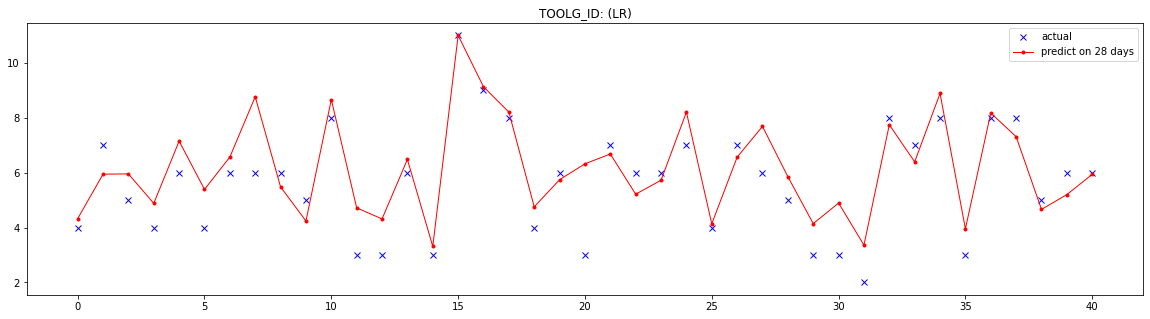

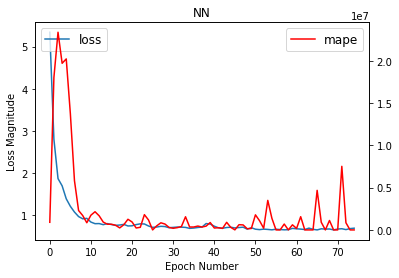

-----RUN NN validation train------
acc: 0.8478197613483484
-----RUN XG test------
acc: 0.8014223472032302


,ID,PART_NO,EQP_NO,QTY,PM,TS,MFG_MONTH,PRkey,PERCENTILE(PM),PERCENTILE(QTY),...,Tool.PERCENTILE(M_NUM),Tool.PERCENTILE(NUM_RECIPE),Tool.PERCENTILE(PROCESS_JOBTIME),Tool.PERCENTILE(PROCESS_TIME),Tool.PERCENTILE(QUE_LOT_RATE),Tool.PERCENTILE(RWORK_LOT_RATE),Tool.PERCENTILE(SAMPLING_RATE),Tool.PERCENTILE(TC),Tool.PERCENTILE(UP_TIME),predict
11,11,85-ECT0010,ECT11,4.0,4.0,0.0,202012,202012_ECT11,0.250000,0.250000,...,0.366725,0.589721,0.287456,0.311847,0.304878,0.560976,0.500871,0.511344,0.843206,3.090128
25,25,85-ECT0010,ECT12,7.0,7.0,0.0,202012,202012_ECT12,0.759582,0.759582,...,0.366725,0.483449,0.317073,0.275261,0.437282,0.104530,0.500871,0.621291,0.343206,5.985893
39,39,85-ECT0010,ECT13,5.0,5.0,0.0,202012,202012_ECT13,0.427700,0.426829,...,0.366725,0.831882,0.142857,0.142857,0.322300,0.895470,0.500871,0.431065,0.433798,5.805407
53,53,85-ECT0010,ECT14,4.0,4.0,0.0,202012,202012_ECT14,0.250000,0.250000,...,0.366725,0.403310,0.435540,0.522648,0.240418,0.289199,0.500871,0.650960,0.733449,3.332778
67,67,85-ECT0010,ECT15,6.0,6.0,0.0,202012,202012_ECT15,0.618467,0.617596,...,0.366725,0.790941,0.381533,0.357143,0.472125,0.817073,0.500871,0.692845,0.034843,6.963045
81,81,85-ECT0010,ECT16,4.0,4.0,0.0,202012,202012_ECT16,0.250000,0.250000,...,0.366725,0.017422,0.522648,0.684669,0.221254,0.672474,0.500871,0.530541,0.062718,3.258233
95,95,85-ECT0010,ECT17,6.0,6.0,0.0,202012,202012_ECT17,0.618467,0.617596,...,0.366725,0.685540,0.454704,0.444251,0.771777,0.371080,0.500871,0.717277,0.114983,6.892284
109,109,85-ECT0010,ECT18,6.0,6.0,0.0,202012,202012_ECT18,0.618467,0.617596,...,0.366725,0.531359,0.517422,0.494774,0.801394,0.660279,0.500871,0.445026,0.019164,7.010472
123,123,85-ECT0010,ECT19,6.0,6.0,0.0,202012,202012_ECT19,0.618467,0.617596,...,0.366725,0.243902,0.245645,0.271777,0.803136,0.749129,0.500871,0.212914,0.149826,5.011946
137,137,85-ECT0010,ECT22,5.0,5.0,0.0,202012,202012_ECT22,0.427700,0.426829,...,0.366725,0.494774,0.226481,0.355401,0.621951,0.646341,0.500871,0.361257,0.768293,3.294941


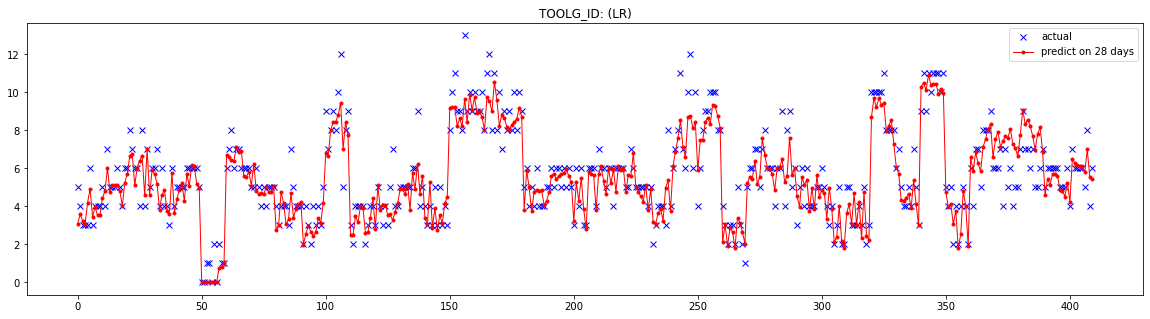

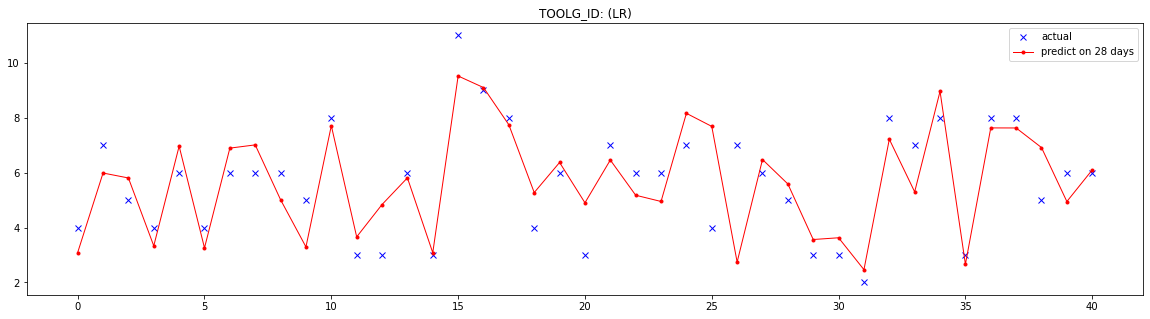

In [323]:

# %%
print('==============================')
print('-----RUN LR train------')
trainLR(df_train)
print('-----RUN LR validation train------')
testLR(df_train)
print('-----RUN LR test------')
testLR(df_test)


# %%
print('==============================')
print('-----RUN XG train------')
trainXG(df_train)
print('-----RUN XG validation train------')
testXG(df_train)
print('-----RUN XG test------')
testXG(df_test)

print('==============================')
print('-----RUN NN train------')
trainNN(df_train)
print('-----RUN NN validation train------')
testNN(df_train)
print('-----RUN XG test------')
testNN(df_test)

In [ ]:
# default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
# default_trans_primitives =  ["day", "year", "month", "weekday","num_words","haversine","num_characters"]


In [ ]:

  
# Default primitives from featuretools
#default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
# default_trans_primitives =  ["day", "year", "month", "weekday", "haversine",   "characters"]
#default_trans_primitives =  ["day", "year", "month", "weekday"]

default_trans_primitives = ["weekday"]
default_agg_primitives=["std"]
feature_matrix2,feature_names2= ft.dfs( entityset = es,
                target_entity='Machine',
                trans_primitives = default_trans_primitives, #對母表 單一筆資料去處理
                agg_primitives=default_agg_primitives, #對 子表做分析
                primitive_options={ 
                    #'std': {'ignore_entities': ['cohorts', 'log']}, 
                    'std': {'include_variables': 
                                {'Product': ['ProdMove', 'MOVE_P'],#子表(1:N的表去計算)
                                'Machine': ['M_NUM'], ## 沒有用因為 要針對子表(1:N的表去計算) 
                                }},
                },
            max_depth=2,
            features_only=False,verbose=True) 


# %%



# %%
#驗證資料
print(feature_matrix2[['MFG_DATE','WEEKDAY(dtMFG_DATE)','TOOLG_ID','STD(Product.MOVE_P)','STD(Product.ProdMove)']].head(1))
print(df_Product[df_Product['PRkey']=='20200122_MA_Alps'].std())
 
# df_Product[(df_Product.PROD_ID=='4GDDR4_25A') & (df_Product.MFG_DATE==20200122)].std()


# %%
#feature_matrix2


# %%
# # Feature Selection

# # Threshold for removing correlated variables
# threshold = 0.95

# # Absolute value correlation matrix
# corr_matrix = feature_names2.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# upper.head(50)




In [ ]:

# %% [markdown]
# # 客制功能

# %%
from featuretools.primitives import make_agg_primitive, make_trans_primitive
from featuretools.variable_types import Text, Numeric,Boolean,Variable


# %%
# custom function so the name of the feature prints out correctly
def make_name(self):
    return "%s_goal_last_%d" % (self.kwargs['Qty1'], self.kwargs['Qty2'])


# %%



# %%
def compare_Qty(Qty1,Qty2):
   return Qty1>Qty2
CompareMove = make_trans_primitive(function=compare_Qty,
                                          input_types=[Numeric, Numeric],
                                          return_type=Boolean,
                                          description="compare_Qty"
                                          #cls_attributes={"generate_name": make_name, "uses_full_entity":True}
                                          )

input_vars = [es["Machine"]["MOVE_QTY"], es["Machine"]["WIP_QTY"]]


# Compare_Move = CompareMove(*input_vars)
# #Compare_Move = CompareMove(Qty1=es["Machine"]["MOVE_QTY"], Qty2=es["Machine"]["WIP_QTY"])

# features = [Compare_Move]


# fm = ft.calculate_feature_matrix(entityset=es, features=features) 


feature_matrix, features = ft.dfs(entityset=es,target_entity="Product",agg_primitives=[],
                        trans_primitives=[CompareMove],
                         primitive_options={ 
                            #'std': {'ignore_entities': ['cohorts', 'log']}, 
                        'CompareMove': {'include_variables': 
                                        {'Product': ['ProdMove', 'MOVE_P'],
                                        }},

                        },
                        max_depth=2)


# %%
feature_matrix


# %%
# Feature lineage graphs
# Understanding Feature Output¶
# In general, Featuretools references generated features through the feature name. In order to make features easier to understand, Featuretools offers two additional tools, featuretools.graph_feature() and featuretools.describe_feature(), to help explain what a feature is and the steps Featuretools took to generate it.
feature = feature_names[54]
ft.graph_feature(feature)


# %%
ft.describe_feature(feature)


# %%
feature_matrix,feature_names =ft.dfs(entityset = es, target_entity = 'WIP',
                       trans_primitives=['weekday', 'day'],
                       #agg_primitives=default_agg_primitives, 
                        verbose = 1,
                       features_only = False)


 


# %%
#累績總計 與總數
 
feature_matrix, features_list = ft.dfs(entityset=es, 
    verbose = 1,
	target_entity='WIP',
    agg_primitives=[], 
	trans_primitives=['cum_sum', 'cum_count'], 
	groupby_trans_primitives=['cum_sum', 'cum_count'], #累積總計、累積總數
    
    ignore_variables={'WIP': ['PRIORITY']}
    
	)
feature_matrix    


# %%
from featuretools.primitives import CumCount
#累績總數
cum_count = CumCount()
cum_count([1, 2, 3, 4, None, 5]).tolist()


# %%
from featuretools.primitives import CumCount
from featuretools.primitives import IsWeekend
#累績總數
cum_count = CumCount()
cum_count([1, 2, 3, 4, None, 5]).tolist()
isWkend = IsWeekend()
feature_matrix, features_list = ft.dfs(entityset=es, 
    verbose = 1,
	target_entity='WIP',
    agg_primitives=[], 
	trans_primitives=['cum_sum','cum_count','is_weekend'], 
	primitive_options={
        'cum_sum': {
                'include_variables':
                    {'WIP': ['WIP_QTY']},
                'ignore_variables':
                    {'WIP': ['IS_MAIN_ROUTE']}    
                    
                    },
		'cum_count': {
                'include_variables':
                    {'WIP': ['WIP_QTY']},
                'ignore_variables':
                    {'WIP': ['IS_MAIN_ROUTE']}    
                    
                    },
        'is_weekend': {
                'ignore_variables':
                        {'WIP': ['ACTUAL_WP_OUT']}}
        }
    
	)



feature_matrix    


# %%



# %%



# %%



# %%
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_X, train_y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(train_X)
X_selected_df = pd.DataFrame(X_new, columns=[train_X.columns[i] for i in range(len(train_X.columns)) if model.get_support()[i]])
X_selected_df.shape


# %%



# %%
random_forest = RandomForestClassifier(n_estimators=2000,oob_score=True)
random_forest.fit(X_selected_df, train_y)


# %%
## 客制function


# %%
'''
from featuretools.primitives import make_agg_primitive, make_trans_primitive
from featuretools.variable_types import Text, Numeric

def avg_goals_previous_n_games(home_team, away_team, home_goals, away_goals, which_team=None, n=1):
    # make dataframe so it's easier to work with
    df = pd.DataFrame({
        "home_team": home_team,
        "away_team": away_team,
        "home_goals": home_goals,
        "away_goals": away_goals
        })

    result = []
    for i, current_game in df.iterrows():
        # get the right team for this game
        team = current_game[which_team]

        # find all previous games that have been played
        prev_games =  df.iloc[:i]

        # only get games the team participated in
        participated = prev_games[(prev_games["home_team"] == team) | (prev_games["away_team"] == team)]
        if participated.shape[0] < n:
            result.append(None)
            continue

        # get last n games
        last_n = participated.tail(n)

        # calculate games per game
        goal_as_home = (last_n["home_team"] == team) * last_n["home_goals"]
        goal_as_away = (last_n["away_team"] == team) * last_n["away_goals"]

        # calculate mean across all home and away games
        mean = (goal_as_home + goal_as_away).mean()

        result.append(mean)

    return result
# custom function so the name of the feature prints out correctly
def make_name(self):
    return "%s_goal_last_%d" % (self.kwargs['which_team'], self.kwargs['n'])
AvgGoalPreviousNGames = make_trans_primitive(function=avg_goals_previous_n_games,
                                          input_types=[Categorical, Categorical, Numeric, Numeric],
                                          return_type=Numeric,
                                          cls_attributes={"generate_name": make_name, "uses_full_entity":True})

input_vars = [es["matches"]["home_team"], es["matches"]["away_team"], es["matches"]["home_goals"], es["matches"]["away_goals"]]
home_team_last1 = AvgGoalPreviousNGames(*input_vars, which_team="home_team", n=1)
home_team_last3 = AvgGoalPreviousNGames(*input_vars, which_team="home_team", n=3)
home_team_last5 = AvgGoalPreviousNGames(*input_vars, which_team="home_team", n=5)
away_team_last1 = AvgGoalPreviousNGames(*input_vars, which_team="away_team", n=1)
away_team_last3 = AvgGoalPreviousNGames(*input_vars, which_team="away_team", n=3)
away_team_last5 = AvgGoalPreviousNGames(*input_vars, which_team="away_team", n=5)

features = [home_team_last1, home_team_last3, home_team_last5,
            away_team_last1, away_team_last3, away_team_last5]


fm = ft.calculate_feature_matrix(entityset=es, features=features) 

fm, feature_defs = ft.dfs(entityset=es, 
                          target_entity="matches",
                          seed_features=features, 
                          agg_primitives=[], 
                          trans_primitives=["day", "month", "year", "weekday", "percentile"])

#https://stackoverflow.com/questions/53579465/how-to-use-featuretools-to-create-features-from-multiple-columns-in-single-dataf                          


